In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
secondary_mushroom = fetch_ucirepo(id=848) 
  
# data (as pandas dataframes) 
X = secondary_mushroom.data.features 
y = secondary_mushroom.data.targets
print(X.shape, y.shape)

(61069, 20) (61069, 1)


In [18]:
import pandas as pd
from ydata_profiling import ProfileReport

df = pd.concat([X, y], axis=1)
df.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,...,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,class
0,15.26,x,g,o,f,e,NaN,w,16.95,17.09,...,y,w,u,w,t,g,NaN,d,w,p
1,16.60,x,g,o,f,e,NaN,w,17.99,18.19,...,y,w,u,w,t,g,NaN,d,u,p
2,14.07,x,g,o,f,e,NaN,w,17.80,17.74,...,y,w,u,w,t,g,NaN,d,w,p
3,14.17,f,h,e,f,e,NaN,w,15.77,15.98,...,y,w,u,w,t,p,NaN,d,w,p
4,14.64,x,h,o,f,e,NaN,w,16.53,17.20,...,y,w,u,w,t,p,NaN,d,w,p


In [96]:
# Generate the report
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_widgets()  # Display as widget in Jupyter Notebook
profile.to_file("your_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/stefan/miniconda3/envs/ml-env/lib/python3.11/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'o'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### **przygotowanie danych**

In [20]:
import os
import numpy as np
from scipy.io import arff
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, OneHotEncoder


LABEL_COL = "class"
SEED = 42

%matplotlib inline

In [53]:
null_data = df.isnull().sum()
null_data_percent = (null_data.values / len(df)) * 100

df_size = len(df)
zipped_null_vals = zip(null_data_percent, df.columns)
zipped_null_vals = sorted(zipped_null_vals, key=lambda x: x[0], reverse=True)
null_vals = [e[0] for e in zipped_null_vals]
null_col_names = [e[1] for e in zipped_null_vals]

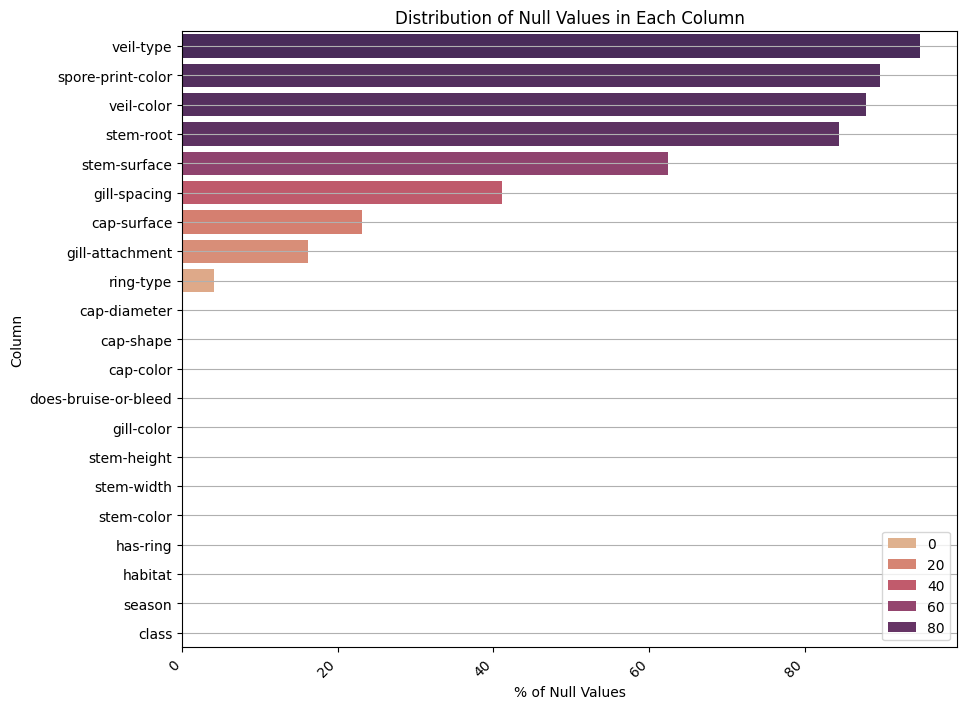

In [54]:
plt.figure(figsize=(10, 8))
sns.barplot(x=null_vals, y=null_col_names, palette="flare", hue=null_vals)
plt.title('Distribution of Null Values in Each Column')
plt.ylabel('Column')
plt.xlabel('% of Null Values')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.show()

In [55]:

null_table_string = "### **Dropped columns displayed in a table below.**\n \
Column name| \% of NaNs \n--- | --- \n"
df_no_nulls = df.copy()

for percent_val, col_name in zipped_null_vals:
    null_table_string += f"{col_name}|{percent_val:.2f}\n"
    if percent_val > 20:
        df_no_nulls.drop(columns=col_name, inplace=True)

display(Markdown(null_table_string))

### **Dropped columns displayed in a table below.**
 Column name| \% of NaNs 
--- | --- 
veil-type|94.80
spore-print-color|89.60
veil-color|87.86
stem-root|84.39
stem-surface|62.43
gill-spacing|41.04
cap-surface|23.12
gill-attachment|16.18
ring-type|4.05
cap-diameter|0.00
cap-shape|0.00
cap-color|0.00
does-bruise-or-bleed|0.00
gill-color|0.00
stem-height|0.00
stem-width|0.00
stem-color|0.00
has-ring|0.00
habitat|0.00
season|0.00
class|0.00


In [56]:
columns = {
    "categorical": [
        "class",
        "cap-shape",
        "cap-color",
        "does-bruise-or-bleed",
        "season",
        "habitat",
        "has-ring",
        "stem-color",
        "gill-color",
        "ring-type",
        "gill-attachment"

    ],
    "numerical": [
        "cap-diameter",
        "stem-height",
        "stem-width"
        ]
}

In [57]:
all_cols = columns["categorical"] + columns["numerical"]
assert len(all_cols) == len(df_no_nulls.columns)
FEATURES_COLS = all_cols.copy()
FEATURES_COLS.remove(LABEL_COL)

In [58]:
FEATURES_COLS

['cap-shape',
 'cap-color',
 'does-bruise-or-bleed',
 'season',
 'habitat',
 'has-ring',
 'stem-color',
 'gill-color',
 'ring-type',
 'gill-attachment',
 'cap-diameter',
 'stem-height',
 'stem-width']

#### **handling nans**

In [59]:
X_train = df_no_nulls[columns["numerical"]].replace([np.inf, -np.inf], np.nan)
# replace nans with median for numcols
for col in columns["numerical"]:
    df_no_nulls[col] = df_no_nulls[col].fillna(df_no_nulls[col].median())

# replace nans with mode for catcols
for col in columns["categorical"]:
    df_no_nulls[col] = df_no_nulls[col].fillna(df_no_nulls[col].mode()[0])

In [60]:
X, y = df_no_nulls[FEATURES_COLS].values, df_no_nulls[LABEL_COL].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=SEED,
                                                    stratify=y)

#change back to pandas dataframe
X_train = pd.DataFrame(X_train, columns=FEATURES_COLS)
X_test = pd.DataFrame(X_test, columns=FEATURES_COLS)

### **outliers detection**

In [61]:
def remove_outliers(df, columns):
    z_scores = np.abs(stats.zscore(df[columns]))
    threshold = 3
    df = df[(z_scores < threshold).all(axis=1)]
    return df

# This is just an example, you need to decide how to handle non-numeric data based on your specific use case
X_train[columns["numerical"]] = X_train[columns["numerical"]].apply(pd.to_numeric, errors='coerce')

X_train = remove_outliers(X_train, columns["numerical"])
y_train = y_train[X_train.index]

In [62]:
X_train.shape, y_train.shape

((47052, 13), (47052,))

In [63]:
X_train.dtypes

cap-shape                object
cap-color                object
does-bruise-or-bleed     object
season                   object
habitat                  object
has-ring                 object
stem-color               object
gill-color               object
ring-type                object
gill-attachment          object
cap-diameter            float64
stem-height             float64
stem-width              float64
dtype: object

### **normalization**

In [69]:
def normalize_num_cols(train_set: pd.DataFrame, test_set: pd.DataFrame, on_cols: list):
    """
    Normalizes numerical columns in the DataFrames using MinMaxScaler.

    Args:
        train_set (pd.DataFrame): The training DataFrame containing the numerical columns to normalize.
        test_set (pd.DataFrame): The test DataFrame containing the numerical columns to normalize.
        on_cols (list): A list of column names indicating which numerical columns to scale.

    Returns:
        pd.DataFrame: A DataFrame where the specified columns have been normalized for both train and test sets.
    """
    scaler = Normalizer()
    
    train_normalized = train_set.copy()
    test_normalized = test_set.copy()
    
    train_normalized[on_cols] = scaler.fit_transform(train_set[on_cols])
    test_normalized[on_cols] = scaler.transform(test_set[on_cols])
    print("✅columns normalized")
    return train_normalized, test_normalized




X_train_normalized, X_test_normalized = normalize_num_cols(
    pd.DataFrame(X_train, columns=FEATURES_COLS),
    pd.DataFrame(X_test, columns=FEATURES_COLS),
    columns["numerical"]
)
print(X_train_normalized.shape, X_test_normalized.shape)

✅columns normalized
(47052, 13) (12214, 13)


In [78]:
def encode_cat_cols(train_df: pd.DataFrame, test_df: pd.DataFrame, columns_to_encode: list):
    """
    Converts categorical column(s) in the DataFrames to one-hot encoded variables using sklearn's OneHotEncoder.

    Args:
        train_df (pd.DataFrame): The training DataFrame containing the categorical columns to encode.
        test_df (pd.DataFrame): The test DataFrame containing the same categorical columns to encode.
        columns_to_encode (list): A list of strings representing the names of the
                                  categorical columns to be one-hot encoded.

    Returns:
        pd.DataFrame, pd.DataFrame: DataFrames with the original categorical columns replaced by
                                     their one-hot encoded counterparts for both train and test sets.
    """
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output  =False, dtype=int)
    encoder.fit(train_df[columns_to_encode])
    
    train_encoded_array = encoder.transform(train_df[columns_to_encode])
    test_encoded_array = encoder.transform(test_df[columns_to_encode])

    train_encoded = pd.DataFrame(train_encoded_array, columns=encoder.get_feature_names_out(columns_to_encode))
    test_encoded = pd.DataFrame(test_encoded_array, columns=encoder.get_feature_names_out(columns_to_encode))
    
    train_df = train_df.drop(columns=columns_to_encode).reset_index(drop=True)
    test_df = test_df.drop(columns=columns_to_encode).reset_index(drop=True)
    
    train_df = pd.concat([train_df, train_encoded], axis=1)
    test_df = pd.concat([test_df, test_encoded], axis=1)
    print("✅columns encoded")
    return train_df, test_df


cols_to_encode = columns["categorical"].copy()
cols_to_encode.remove(LABEL_COL)
X_train_encoded, X_test_encoded = encode_cat_cols(X_train_normalized, X_test_normalized, cols_to_encode)
print(X_train_normalized.shape, X_test_normalized.shape)

✅columns encoded
(47052, 13) (12214, 13)


In [79]:
X_train_encoded

,cap-diameter,stem-height,stem-width,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x,...,ring-type_p,ring-type_r,ring-type_z,gill-attachment_a,gill-attachment_d,gill-attachment_e,gill-attachment_f,gill-attachment_p,gill-attachment_s,gill-attachment_x
0,0.558933,0.609834,0.561869,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1,0.625595,0.349253,0.697606,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.423542,0.545058,0.723550,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0.417666,0.490667,0.764723,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0.419811,0.487440,0.765612,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47047,0.456013,0.298652,0.838367,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
47048,0.306948,0.468910,0.828195,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
47049,0.261576,0.924073,0.278689,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
47050,0.447957,0.581233,0.679340,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## **model training**

#### **hiper-params search**

In [92]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 4, 8],
    "ccp_alpha": [0, 0.01, 0.02, 0.05]
}

In [93]:
print(X_train_encoded.shape, y_train.shape)

(47052, 78) (47052,)


In [94]:
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_encoded, y_train)

/home/stefan/miniconda3/envs/ml-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
120 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/home/stefan/miniconda3/envs/ml-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stefan/miniconda3/envs/ml-env/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/stefan/miniconda3/envs/ml-env/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_par

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0, 0.01, 0.02, 0.05],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15],
                         'min_samples_split': [1, 2, 4, 8]},
             scoring='accuracy')

In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

In [84]:
from sklearn.metrics import classification_report

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_encoded)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           e       0.99      0.98      0.99      5436
           p       0.98      1.00      0.99      6778

    accuracy                           0.99     12214
   macro avg       0.99      0.99      0.99     12214
weighted avg       0.99      0.99      0.99     12214



In [95]:
# get params of best model
bmp = best_model.get_params()
print(bmp)

{'ccp_alpha': 0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


In [85]:
# fir tree and test on train data
best_model.fit(X_train_encoded, y_train)
train_predictions = best_model.predict(X_train_encoded)
print(classification_report(y_train, train_predictions))

              precision    recall  f1-score   support

           e       1.00      1.00      1.00     20408
           p       1.00      1.00      1.00     26644

    accuracy                           1.00     47052
   macro avg       1.00      1.00      1.00     47052
weighted avg       1.00      1.00      1.00     47052



In [90]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

              precision    recall  f1-score   support

           e       0.99      0.98      0.99      5436
           p       0.98      1.00      0.99      6778

    accuracy                           0.99     12214
   macro avg       0.99      0.99      0.99     12214
weighted avg       0.99      0.99      0.99     12214



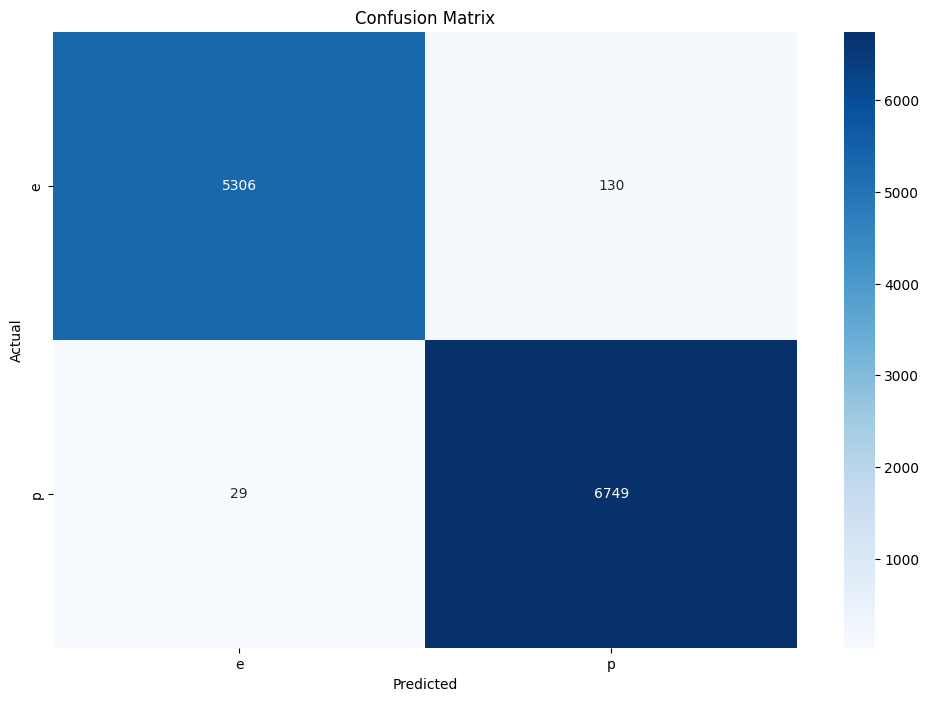

In [87]:
# test on test data
test_predictions = best_model.predict(X_test_encoded)
print(classification_report(y_test, test_predictions))

plot_confusion_matrix(y_test, test_predictions, best_model.classes_)

### **visualization**

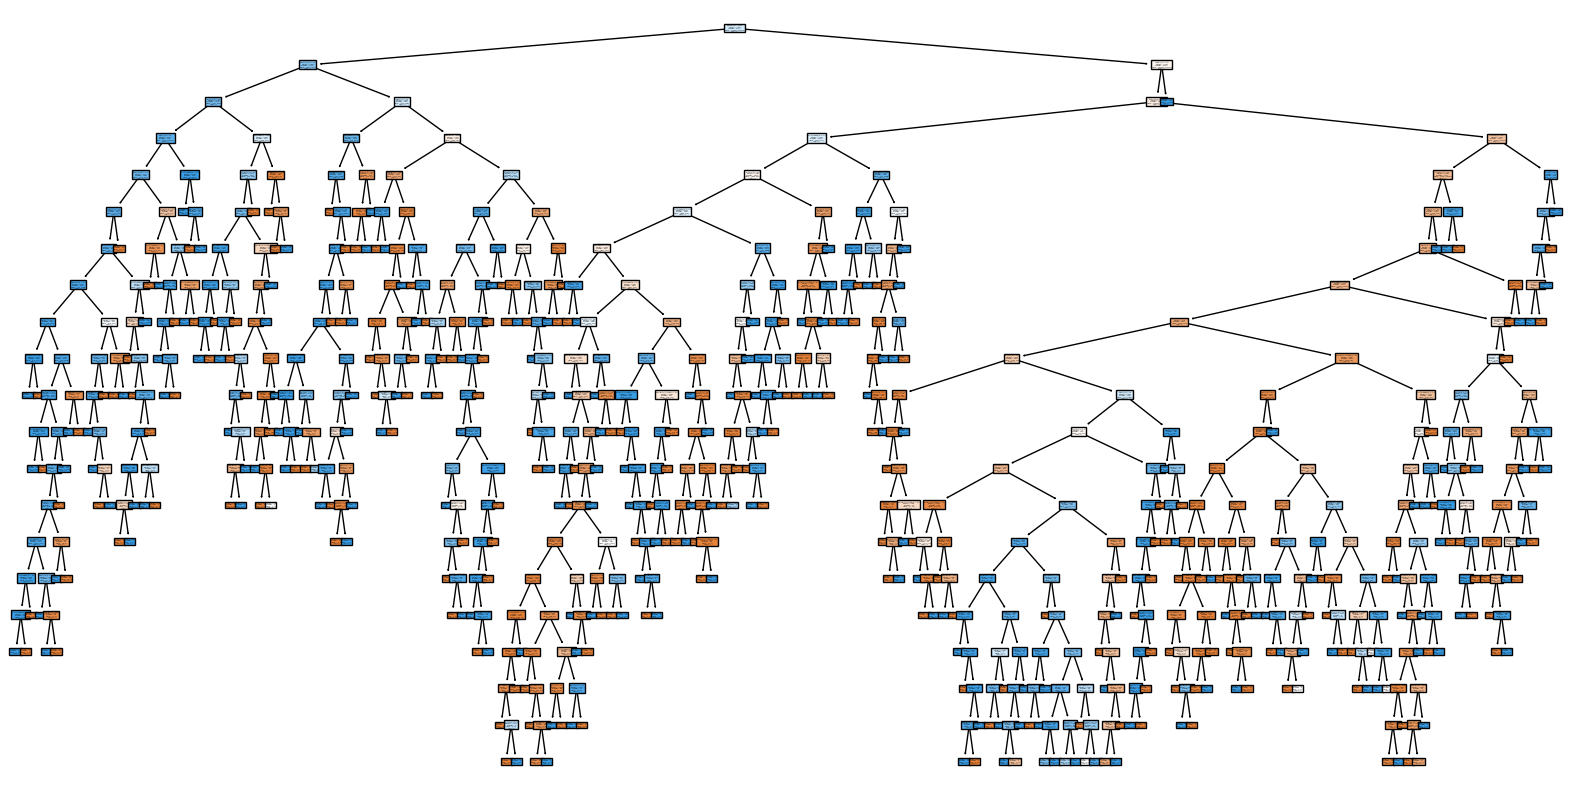

In [88]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, feature_names=X_train_encoded.columns, class_names=best_model.classes_)
plt.show()

/tmp/ipykernel_18175/3914725896.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=LABEL_COL, data=df_no_nulls, palette='viridis')


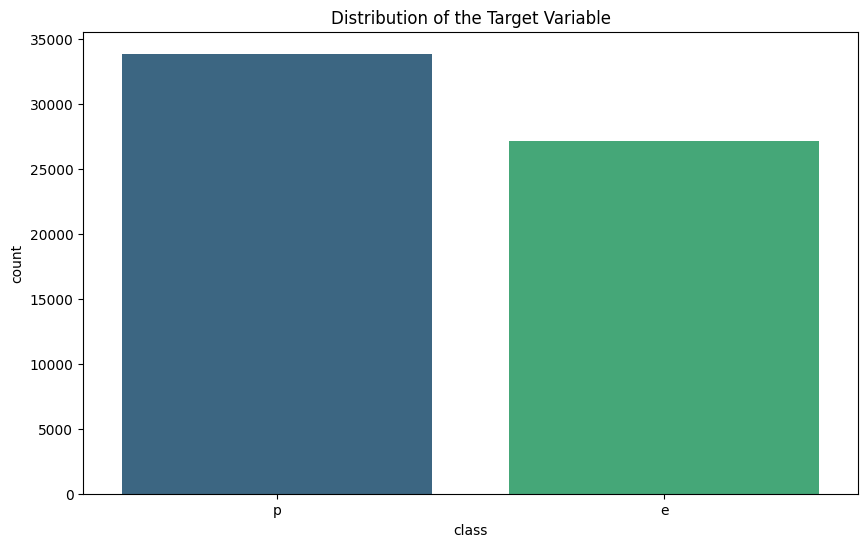

In [89]:
# plot distribution of a target variable
plt.figure(figsize=(10, 6))
sns.countplot(x=LABEL_COL, data=df_no_nulls, palette='viridis')
plt.title('Distribution of the Target Variable')
plt.show()

### **weights manipulation**

In [ ]:
weighted_tree = DecisionTreeClassifier(class_weight={"p": 0.2, "e": 0.8})
weighted_tree.fit(X_train_encoded, y_train)
weighted_predictions = weighted_tree.predict(X_test_encoded)
print(classification_report(y_test, weighted_predictions))

              precision    recall  f1-score   support

           e       0.99      0.99      0.99      5436
           p       0.99      1.00      0.99      6778

    accuracy                           0.99     12214
   macro avg       0.99      0.99      0.99     12214
weighted avg       0.99      0.99      0.99     12214



In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(weighted_tree, filled=True, feature_names=X_train_encoded.columns, class_names=best_model.classes_)
plt.show()